In [ ]:
import torchvision

from torch import cuda, device, Tensor
from src.plots import plot_vae_training_result, plot_image
from src.vae.mnist_vae import ConditionalVae
from src.image_classifier.image_classifier import MNISTClassifier

device = device('cuda' if cuda.is_available() else 'cpu')

In [2]:
training_data = torchvision.datasets.MNIST(root='../data/MNIST_train', train=True, download=True, transform=torchvision.transforms.ToTensor())
testing_data = torchvision.datasets.MNIST(root='../data/MNIST_test', train=False, download=True, transform=torchvision.transforms.ToTensor())
print(training_data)
print(testing_data)

# input = training_data.data[:60000] / 255.0   # normalizing necessary to make pixels in [0, 1] range for FID
input = training_data.data[:60000]
labels = training_data.targets[:60000]

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data/MNIST_train
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data/MNIST_test
    Split: Test
    StandardTransform
Transform: ToTensor()


C:\Users\trinity\projects\Federated-Learning-PyTorch\venv\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Finished epoch:  1
Finished epoch:  2
Finished epoch:  3
Finished epoch:  4
Finished epoch:  5


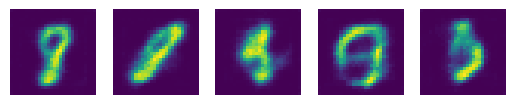

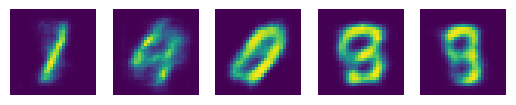

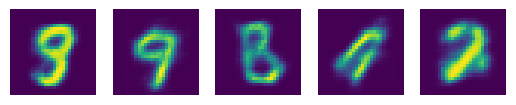

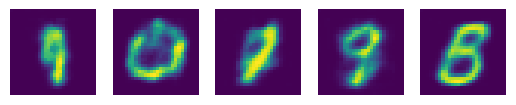

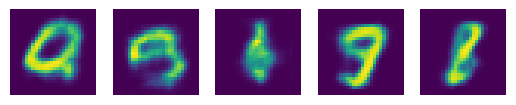

In [3]:
# Train VAE
vae = ConditionalVae(dim_encoding=10).to(device)

vae_model, vae_loss_li, kl_loss_li = vae.train_model(
    training_data=training_data,
    batch_size=32,
    epochs=5,
    learning_rate=0.001
)

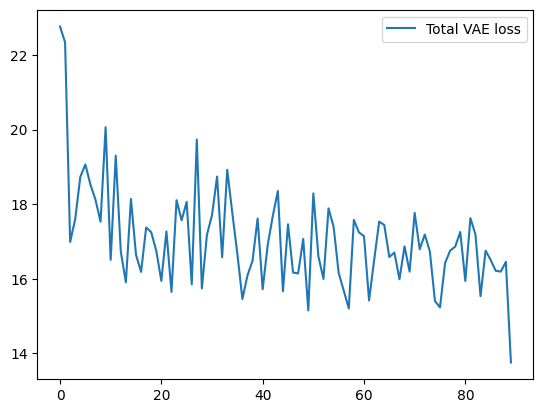

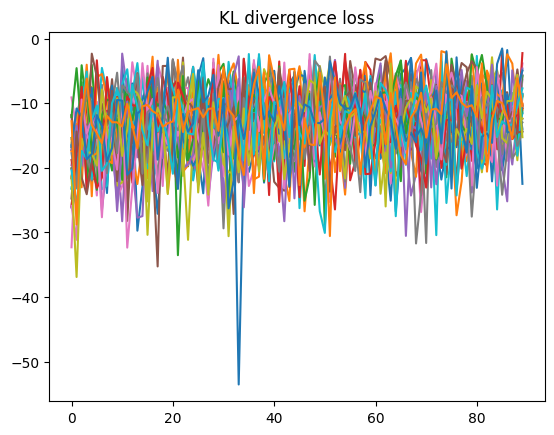

In [4]:
# move tensors to cpu before converting to np array
np_kl_loss_li = []

for output in kl_loss_li:
    if isinstance(output, Tensor):
        np_kl_loss_li.append(output.cpu().detach().numpy())

# plot results
plot_vae_training_result(
    input=input,
    labels=labels,
    vae_model=vae_model,
    vae_loss_li=vae_loss_li,
    kl_loss_li=np_kl_loss_li
)

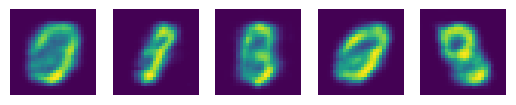

In [8]:
images = vae.generate_data(n_samples=5, target_label=1)
plot_image(images)

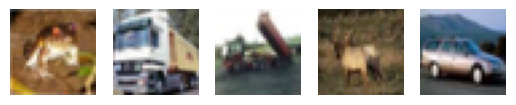

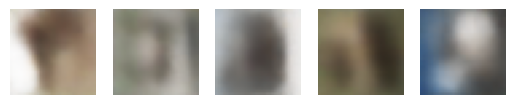

In [6]:
from src.sampling import split_dirichlet

# generate imbalanced data set for comparison of distribution of input vs distribution of generated images
training_data = torchvision.datasets.MNIST(root='../data/MNIST_train', train=True, download=True, transform=torchvision.transforms.ToTensor())

input = training_data.data[:60000]
labels = training_data.targets[:60000]

users_data = split_dirichlet(dataset=training_data, num_users=4, is_cfar=False, beta=0.5)

total_input = []
total_labels = []
total_counts = []
for user_idx in users_data:
    images = []
    outputs = []
    counts = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

    for data_idx in users_data[user_idx]:
        image = input[int(data_idx)]
        images.append(image)
        label = labels[int(data_idx)]
        outputs.append(label)
        counts[label] +=1
    total_input.append(images)
    total_labels.append(outputs)
    total_counts.append(counts)

user_idx = 0
sample_input = total_input[user_idx]
sample_label = total_labels[user_idx]

input_tensor = torch.stack(sample_input)
label_tensor = torch.stack(sample_label)

plot_image_label_two (input_tensor.cpu().detach().numpy(), label_tensor.cpu().detach().numpy())

assert input_tensor.shape[0] == label_tensor.shape[0]

training_data.data = input_tensor
training_data.targets = label_tensor

assert training_data.data.shape == input_tensor.shape
assert training_data.targets.shape == label_tensor.shape


# Train VAE on imbalanced dataset
vae_imbalanced = VaeAutoencoder(dim_encoding=2)

_, _, _ = vae_imbalanced.train_model(
    training_data,
    batch_size=50,
    beta=1000,
    epochs=20
)

gen_image = vae_imbalanced.generate_data(n_samples=sum(total_counts[user_idx]))
gen_output = classifier.generate_labels(gen_image)
gen_counts = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
for tensor_label in gen_output:
    gen_counts[tensor_label[0]]+=1

# plot generated data
plot_image_label_two(gen_image.cpu().detach().numpy(), gen_output.cpu().detach().numpy())

print("Input counts: ", total_counts[user_idx])
print("Generated counts: ", gen_counts)

In [ ]:
# x = vae.generate_data(n_samples=10000)
# print("Number of images: ", x.shape[0])
# 
# labels = classifier.generate_labels(x)
# print("Labels: ", labels.shape)

In [ ]:
# # Determine FID
# # generate 500 images
# syn_input, _ = vae.generate_data(n_samples=500)
# input = input[:500]
# 
# input_rgb = input.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)
# syn_input_rgb = syn_input.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)
# 
# # compute FID score
# fid_score = frechet_inception_distance(input_rgb, syn_input_rgb)
# print("Frechet Inception Distance: ", fid_score)